Writer: Yinbo Song
Email: songyinbo@outlook.com
Date: 2023.07.03

In [1]:
%reset -f
import numpy as np
import pandas as pd
%clear

# Import photogrammetric results, only sparse point cloud information
points = pd.read_excel('data\zxt\zxt_14000Pa_failure.xlsx', sheet_name = 'points')
#links = pd.read_excel('data\zxt_14000Pa_failure.xlsx', sheet_name = 'links')

在以下代码块中需要输入靶点的行数和列数

In [2]:
# Sparse point cloud renumbering
points_copy = points.sort_values(by='point_y')
group = []
points_new = pd.DataFrame()
num_rowx = 16 # Enter the number of rows in the x-direction
num_rowy = 16 # Enter the number of columns in the y-direction

for i in range(num_rowx):
        group.append(points_copy.iloc[num_rowy * i : num_rowy * (i + 1), ])
        group[i] = group[i].sort_values(by='point_x')
        #points_new = points_new.append(group[i])
        points_new = pd.concat([points_new, group[i]], ignore_index=True)
points_new = points_new.reset_index(drop=True)

for i in range(len(points_new['point_ID'])):
        points_new.loc[i, 'point_ID'] = i
points = points_new
del points_new, points_copy, group, num_rowx, num_rowy, i

In [3]:
# Solving for the direction of each point load in the point cloud (KDTreeSearch)
import open3d as o3d

xyz = points.values[:, 1:4]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
#o3d.visualization.draw_geometries([pcd])

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=200, max_nn=30))
o3d.geometry.PointCloud.orient_normals_to_align_with_direction(pcd, orientation_reference=np.array([0.0, 0.0, 1.0]))
#o3d.visualization.draw_geometries([pcd], point_show_normal=True)   # Unit normal vector presentation of a point cloud

pcd_normals = np.asarray(pcd.normals)
#print(pcd_normals)

name = ['normal_x', 'normal_y', 'normal_z']
points_normals = pd.DataFrame(data = pcd_normals, columns = name)
points_normals.insert(0, 'point_ID', points['point_ID'], allow_duplicates=False)

del xyz, pcd, pcd_normals, name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


在以下代码块中需要输入靶点间距（单位为mm）以及缩放倍数

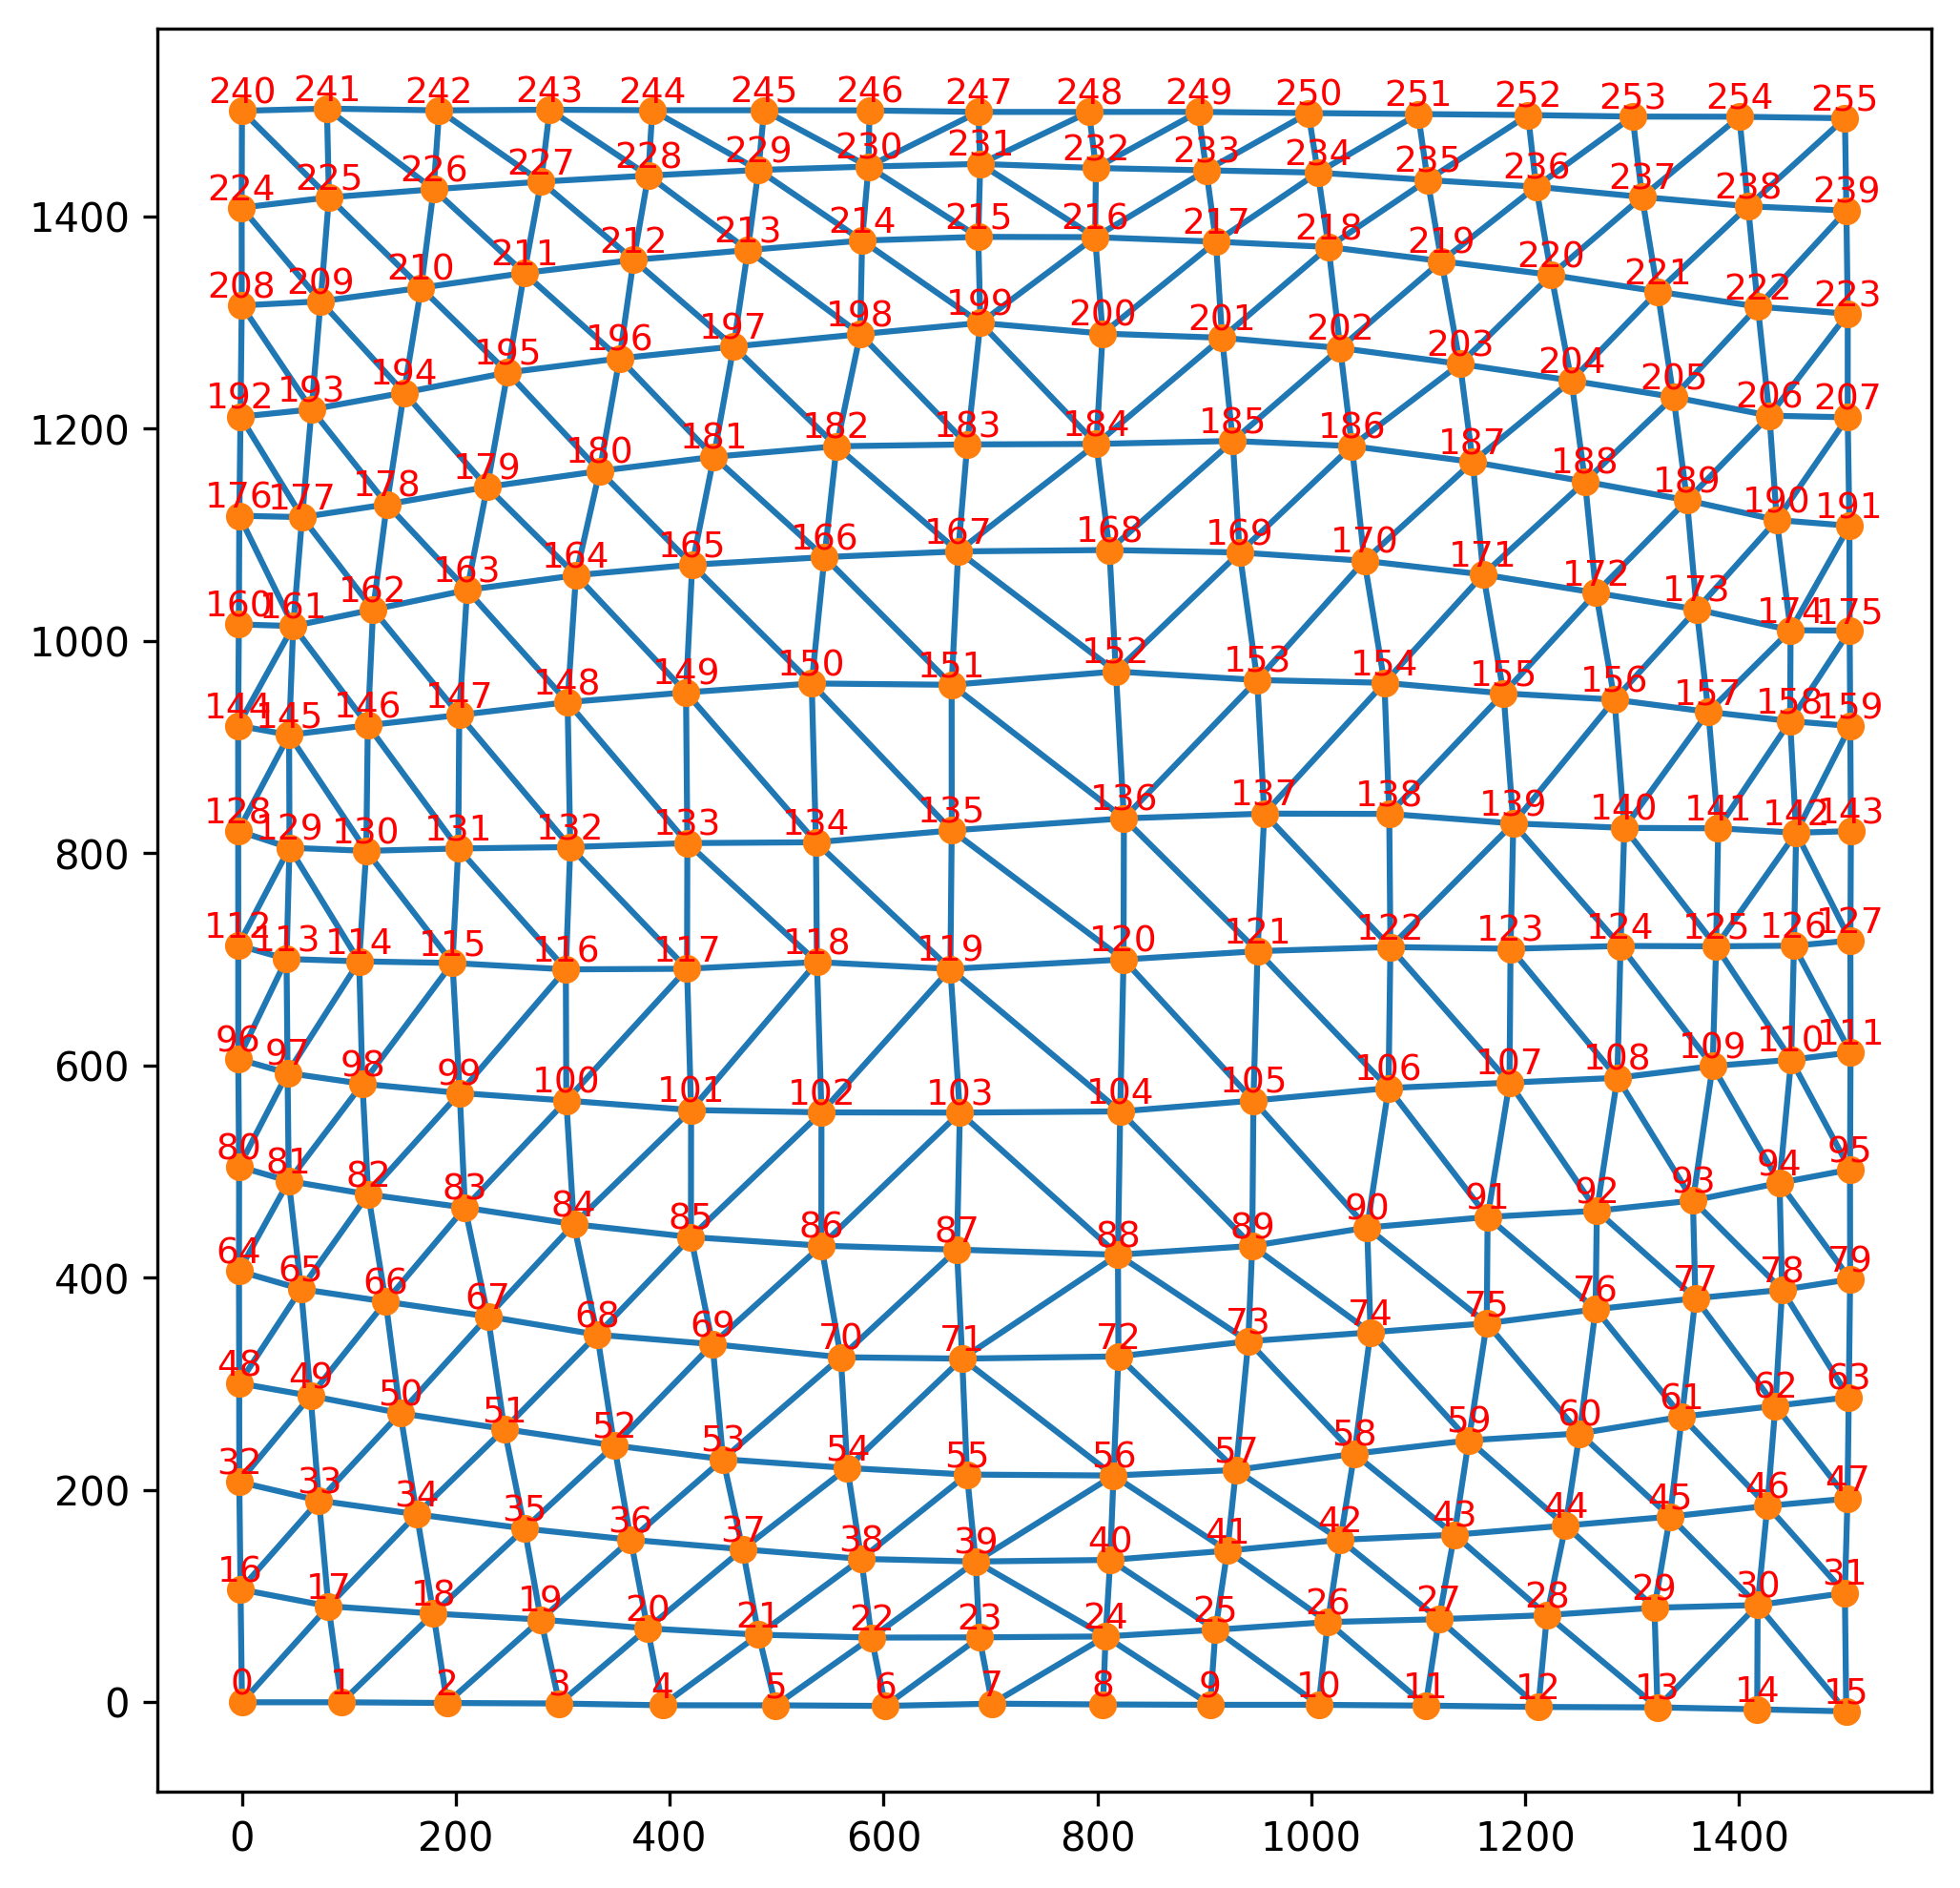

In [4]:
# Triangular meshing of sparse point clouds using triangular dissections to obtain point-element correspondences
import matplotlib.tri as mtri
from matplotlib.tri import Triangulation
from matplotlib import pyplot as plt
plt.close("all")
import math 

# Take the XOY plane projection of the point cloud for triangulation
xy = np.array(points[['point_x', 'point_y']])
triang = mtri.Triangulation(xy[:,0], xy[:,1])
element_nodes = triang.triangles

# Remove the narrow triangles at the boundary in the triangulation result
distance = 100
s = 1.8 # Scaling of the distance, adjusting the parameter until the number of cells in element_nodes_new is equal to the theoretical value
node0 = element_nodes[:, 0]
node1 = element_nodes[:, 1]
node2 = element_nodes[:, 2]

I = []
for i in range(element_nodes.shape[0]):
    x0_x1 = abs(points['point_x'][node0[i]] - points['point_x'][node1[i]])
    y0_y1 = abs(points['point_y'][node0[i]] - points['point_y'][node1[i]])
    x1_x2 = abs(points['point_x'][node1[i]] - points['point_x'][node2[i]])
    y1_y2 = abs(points['point_y'][node1[i]] - points['point_y'][node2[i]])
    x0_x2 = abs(points['point_x'][node0[i]] - points['point_x'][node2[i]])
    y0_y2 = abs(points['point_y'][node0[i]] - points['point_y'][node2[i]])
    if x0_x1>distance*s or y0_y1>distance*s\
         or x1_x2>distance*s or y1_y2>distance*s\
         or x0_x2>distance*s or y0_y2>distance*s :
        I.append(i)
    else:
        pass
element_nodes = np.delete(element_nodes, I, axis=0)
triang = mtri.Triangulation(xy[:,0], xy[:,1], element_nodes)

del distance, s, node0, node1, node2, \
    x0_x1, y0_y1, x1_x2, y1_y2, x0_x2, y0_y2, \
    I, i

plt.figure(dpi=300, figsize=(8,8))
plt.triplot(triang, marker="o")

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points['point_ID'][i],
            fontsize = 9,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')
del i

In [5]:
# Converts triangular elements to quadrilateral elements
def element_to_links(element):
    df = pd.DataFrame(index=range(3), columns=range(2))
    element.sort()
    df.iloc[0, 0] = element[0]
    df.iloc[0, 1] = element[1]
    df.iloc[1, 0] = element[0]
    df.iloc[1, 1] = element[2]
    df.iloc[2, 0] = element[1]
    df.iloc[2, 1] = element[2]
    return(df)
def link_angle(ID1, ID2):
    x1 = points.loc[points['point_ID'] == ID1]['point_x'].iloc[0]
    y1 = points.loc[points['point_ID'] == ID1]['point_y'].iloc[0]
    x2 = points.loc[points['point_ID'] == ID2]['point_x'].iloc[0]
    y2 = points.loc[points['point_ID'] == ID2]['point_y'].iloc[0]
    dx = x2 - x1
    dy = y2 - y1
    radian = math.atan2(dy, dx)
    degree = math.degrees(radian)
    return degree
def link_length(ID1, ID2):
    x1 = points.loc[points['point_ID'] == ID1]['point_x'].iloc[0]
    y1 = points.loc[points['point_ID'] == ID1]['point_y'].iloc[0]
    z1 = points.loc[points['point_ID'] == ID1]['point_z'].iloc[0]
    x2 = points.loc[points['point_ID'] == ID2]['point_x'].iloc[0]
    y2 = points.loc[points['point_ID'] == ID2]['point_y'].iloc[0]
    z2 = points.loc[points['point_ID'] == ID2]['point_z'].iloc[0]
    length = math.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    return length

df1 = element_to_links(element_nodes[0])
for i in range(element_nodes.shape[0]):
    element = element_nodes[i]
    df2 = element_to_links(element)
    df1 = pd.concat([df1, df2], axis=0)
df1 = df1.drop_duplicates()
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)
degree0 = 20 # change the angle to fuse triangle elements into quadrilateral elements

for i in range(df1.shape[0]):
    ID1 = df1.iloc[i, 0]
    ID2 = df1.iloc[i, 1]
    if 0+degree0 < link_angle(ID1, ID2) < 90-degree0 or \
       90+degree0 < link_angle(ID1, ID2) < 180-degree0:
       df1.iloc[i] = np.nan
df1.dropna(axis=0, how='all', inplace=True)

del degree0, df2, element, i, ID1, ID2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\3826699061.py:54: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID1 = np.int0(links.loc[i, 'point1_ID'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\3826699061.py:55: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID2 = np.int0(links.loc[i, 'point2_ID'])


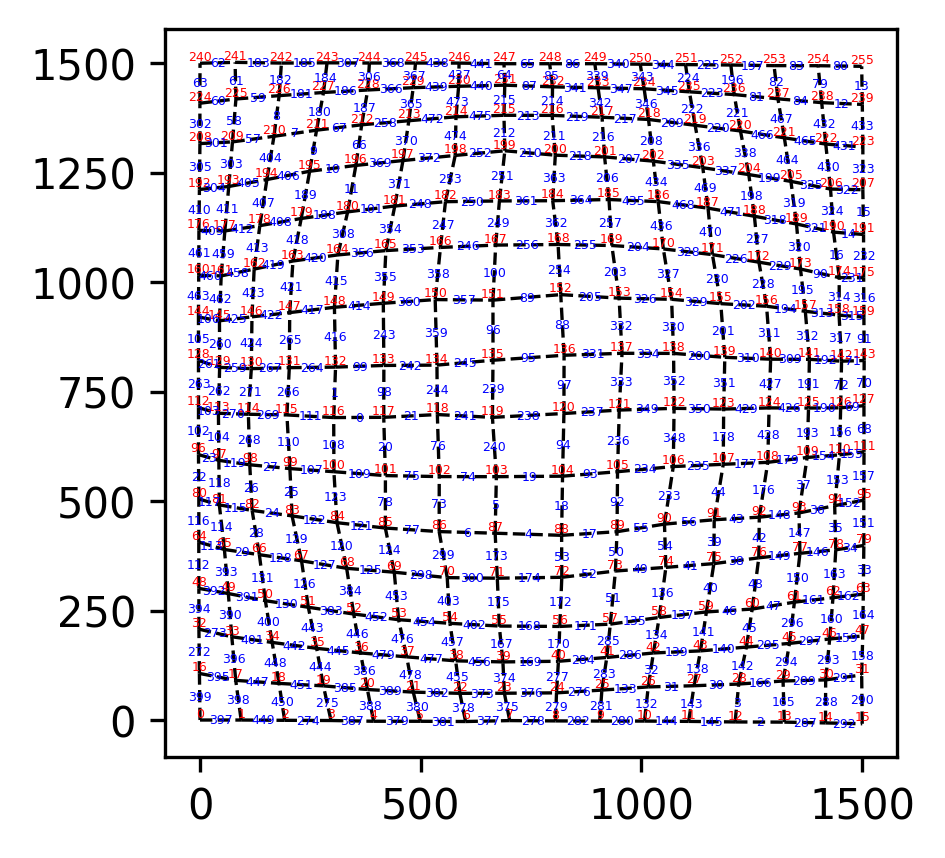

In [6]:
# Create a dataframe of links to store membrane link information
df3 = pd.DataFrame(columns = ['point1_ID', 'point1_x', 'point1_y', 'point1_z', 'point2_ID', 'point2_x', 'point2_y', 'point2_z', 'length', 'angle'])
df3['point1_ID'] = df1.iloc[:, 0]
df3['point2_ID'] = df1.iloc[:, 1]
df3 = df3.reset_index(drop=True)
# Generate the coordinate values of the two end points of the membrane link by retrieving the point IDs
for i in range(df3.shape[0]):
    p1_ID = df3.loc[i, 'point1_ID']
    for j in range(points.shape[0]):
        p_ID = points.loc[j, 'point_ID']
        if p1_ID == p_ID:
            df3.loc[i, 'point1_x'] = points.loc[j, 'point_x']
            df3.loc[i, 'point1_y'] = points.loc[j, 'point_y']
            df3.loc[i, 'point1_z'] = points.loc[j, 'point_z']
        else:
            pass
    
    p2_ID = df3.loc[i, 'point2_ID']
    for j in range(points.shape[0]):
        p_ID = points.loc[j, 'point_ID']
        if p2_ID == p_ID:
            df3.loc[i, 'point2_x'] = points.loc[j, 'point_x']
            df3.loc[i, 'point2_y'] = points.loc[j, 'point_y']
            df3.loc[i, 'point2_z'] = points.loc[j, 'point_z']
        else:
            pass
links = df3
links.insert(0, 'link_ID', links.index)
for i in range(links.shape[0]):
    ID1 = links.loc[i, 'point1_ID']
    ID2 = links.loc[i, 'point2_ID']
    links.loc[i, 'length'] = link_length(ID1, ID2)
    links.loc[i, 'angle'] = link_angle(ID1, ID2)

# Drawing the quadrilateral grid
plt.figure(figsize=(8/2.54, 8/2.54), dpi=300)
for i in range(links.shape[0]):
    x_values = [links.loc[i, 'point1_x'], links.loc[i, 'point2_x']]
    y_values = [links.loc[i, 'point1_y'], links.loc[i, 'point2_y']]
    plt.plot(x_values, y_values,\
             color = 'black', linestyle = '--', linewidth = 0.8)

# Add point cloud numbers
for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points.loc[i, 'point_ID'],
            fontsize = 3,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

# Add member link numbers
for i in range(links.shape[0]):
    ID1 = np.int0(links.loc[i, 'point1_ID'])
    ID2 = np.int0(links.loc[i, 'point2_ID'])
    plt.text((points.loc[ID1, 'point_x'] + points.loc[ID2, 'point_x'])/2,\
             (points.loc[ID1, 'point_y'] + points.loc[ID2, 'point_y'])/2,
            links.loc[i, 'link_ID'],
            fontsize = 3,
            color = 'b', 
            horizontalalignment = 'center',
            verticalalignment = 'center')
del i, x_values, y_values, ID1, ID2

The value of the air pressure in MPa to which the membrane surface is subjected needs to be entered in the following code block.

In [7]:
# Solve for the magnitude of each point load in the point cloud (slave area)

# Adding element numbers to the 'element-node' relationship
name = ['node0', 'node1', 'node2']
element_to_points = pd.DataFrame(data = element_nodes, columns = name)
element_to_points.insert(0, 'element_ID', np.arange(0, element_nodes.shape[0], 1), allow_duplicates=False)
del element_nodes

# Query the element numbers associated with the node, and the nodes related to each element
elements_list = []
for i in range(points.shape[0]):
    ID = points['point_ID'][i]
    df0 = element_to_points[ID == element_to_points.node0]
    df1 = element_to_points[ID == element_to_points.node1]
    df2 = element_to_points[ID == element_to_points.node2]
    related_elements = pd.concat([df0, df1, df2])
    elements_list.append(related_elements)
del name, i, ID, df0, df1, df2, related_elements

# Calculate the area of each element based on the nodes related to the element
elements_areas = elements_list
for i in range(points.shape[0]):
    elements_areas[i].insert(4, 'element_area', 0, allow_duplicates=False)
    elements = elements_list[i]
    for j in range(elements.shape[0]):
        element = elements.iloc[j]
        P0_ID = np.int0(element['node0'])
        P1_ID = np.int0(element['node1'])
        P2_ID = np.int0(element['node2'])
        P0 = np.array(points.iloc[P0_ID, 1:4])
        P1 = np.array(points.iloc[P1_ID, 1:4])
        P2 = np.array(points.iloc[P2_ID, 1:4])
        A = P1 - P0
        B = P2 - P0
        area = np.linalg.norm(np.cross(A, B)) / 2
        elements_areas[i].iloc[j, 4] = area
del i, j, elements, element, \
    P0_ID, P1_ID, P2_ID, \
    P0, P1, P2, A, B, area, elements_list

# Calculate the slave area of each node
points.insert(4, 'subordinate area', 0, allow_duplicates=False)
for i in range(points.shape[0]):
    element = elements_areas[i]
    subordinate_area = (element['element_area'].sum() / 3)
    points.loc[i, 'subordinate area'] = subordinate_area
del i, element, subordinate_area, elements_areas

# Obtain the load vector P for each node
Pressure = 0.014    # Air pressure on the membrane surface, in MPa
P_list = points_normals
for i in range(P_list.shape[0]):
    P_list.iloc[i, 1] = P_list.iloc[i, 1] * points.loc[i, 'subordinate area'] * Pressure
    P_list.iloc[i, 2] = P_list.iloc[i, 2] * points.loc[i, 'subordinate area'] * Pressure
    P_list.iloc[i, 3] = P_list.iloc[i, 3] * points.loc[i, 'subordinate area'] * Pressure
del i, points_normals

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\2850150449.py:27: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P0_ID = np.int0(element['node0'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\2850150449.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P1_ID = np.int0(element['node1'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\2850150449.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  P2_ID = np.int0(element['node2'])


In [8]:
# Solve the coordinate difference matrix (topological relations) of the deformed point cloud (quadrilateral mesh)
# Plot the membrane links of the deformed sparse point cloud to obtain the correspondence of point i with points j, k, m, n

# Output the neighbouring nodes associated with each node
connected_points = []
links_new = links[['point1_ID', 'point2_ID']]
for i in range(points.shape[0]):
    data = links_new[links_new.eq(i).any(axis=1)]
    arr = data.to_numpy()
    arr = arr.reshape(-1)
    arr = list(arr)
    arr = np.unique(arr, axis=0)
    arr = np.delete(arr, np.where(arr == i))
    connected_points.append(arr)
internal_connected_points = [sub_lst for sub_lst in connected_points if len(sub_lst) == 4]
del connected_points, links_new, arr

In [9]:
# Generate X matrix and store
X_list = []
for i in range(len(internal_connected_points)):
    # Calculate the ID value of node i
    ID_i= np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))
    # Coordinate copy of node i
    times = len(internal_connected_points[i])
    coords = np.array(points.loc[ID_i, ['point_x', 'point_y', 'point_z']])
    mat = np.tile(coords, (times, 1)).T
    # Coordinate splicing of nodes around node i
    coordinates = []
    for j in range(times):
        index = np.int0(internal_connected_points[i][j])
        new_coordinate = np.array(points.loc[index, ['point_x', 'point_y', 'point_z']])
        coordinates.append(new_coordinate)
    matrix = np.array(coordinates).T
    # Assembling the X-matrix and storing it
    X = np.concatenate((mat, matrix), axis=0)
    X_list.append(X)
#del ID_i, times, coords, mat, coordinates, index, new_coordinate, matrix, X

# Generate C-matrix and store
eye = np.eye(3)
neg_eye = -np.eye(3)
C = np.concatenate((eye, neg_eye), axis=1)
#del i, j, data, eye, neg_eye

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\148878176.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID_i= np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\148878176.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  index = np.int0(internal_connected_points[i][j])


In [10]:
# Generate Node Vectors
P_vectors = []
for i in range(P_list.shape[0]):
    row = P_list.loc[i]
    col = np.reshape(row.values[1:4], (-1, 1))
    P_vectors.append(col)
del i, row, col

# Calculation of membrane link force density values
q_list = []
for i in range(len(internal_connected_points)):
    q_coffcient_matrix = np.dot(\
                            np.dot(\
                                np.dot(X_list[i].T, C.T), \
                            C), \
                        X_list[i])
    p_cofficient_matrix = np.dot(X_list[i].T, C.T)

    ID_i= np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))
    q = np.dot(\
            np.dot(\
                np.linalg.pinv(q_coffcient_matrix), \
            p_cofficient_matrix), \
        P_vectors[ID_i])
    q_list.append(q)
del i, ID_i, q

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\630433774.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID_i= np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))


In [11]:
# Create a set of IDs for the two endpoints of the membrane link, which is used to find the membrane link ID value corresponding to the value of the force density
links_set = []
for i in range(links.shape[0]):
    p1 = links.loc[i, 'point1_ID']
    p2 = links.loc[i, 'point2_ID']
    s1 = set([p1, p2])
    links_set.append(s1)
del i, p1, p2, s1

# Store the solved force density in the membrane link
links['force_density'] = [[] for _ in range(len(links))]
for i in range(len(internal_connected_points)):
    ID_i = np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))
    for j in range(len(internal_connected_points[i])):
        ID_j = internal_connected_points[i][j]
        s2 = set([ID_i, ID_j])
        for k in range(len(links_set)):
            if s2 == links_set[k]:
                link_ID = k
            else:
                pass
        links.loc[link_ID, 'force_density'].append(q_list[i][j])
del i, ID_i, j, ID_j, s2, k, link_ID

# Multiply the average value of the force density of the membrane link by the length of the membrane link to obtain the membrane link force.
links['link_force'] = None
for i in range(len(links)):
    link_len = links.loc[i, 'length']
    arr = links.loc[i, 'force_density']
    if arr == []:
        pass
    else:
        avg = np.mean(arr)
        link_force = avg * link_len
        links.loc[i, 'link_force'] = link_force
del i, link_len, arr, avg, link_force

links['link_force'][links['link_force'] < 0]  = 0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\841725725.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID_i = np.int0(sum(internal_connected_points[i]) / len(internal_connected_points[i]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\841725725.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links['link_force'][links['link_force'] < 0]  = 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\3194922096.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  p1 = np.int0(links.loc[i, 'point1_ID'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\3194922096.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  p2 = np.int0(links.loc[i, 'point2_ID'])


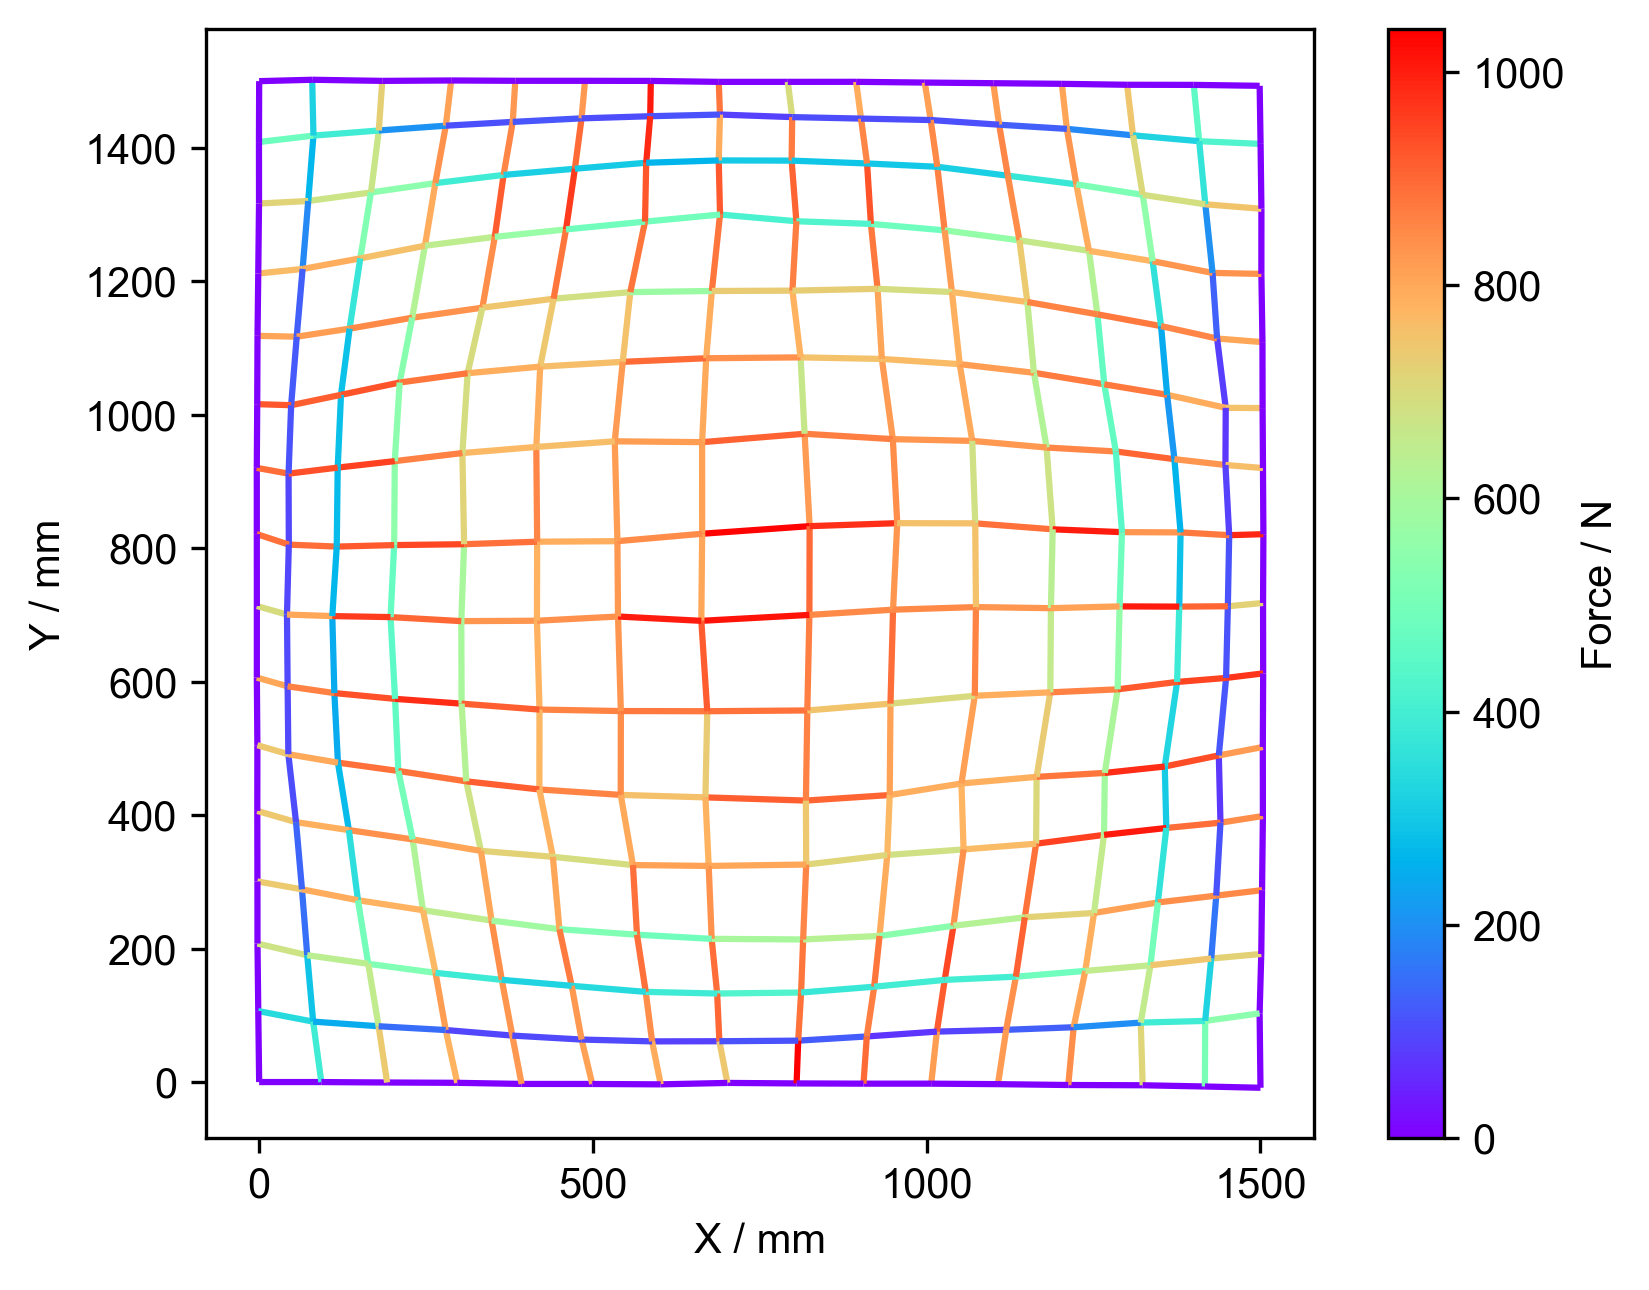

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')

lines = []
for i in range(len(links)):
    p1 = np.int0(links.loc[i, 'point1_ID'])
    p2 = np.int0(links.loc[i, 'point2_ID'])
    p1x = points.loc[p1, 'point_x']
    p1y = points.loc[p1, 'point_y']
    p2x = points.loc[p2, 'point_x']
    p2y = points.loc[p2, 'point_y']
    line = [(p1x, p1y), (p2x, p2y)]
    lines.append(line)
del p1, p2, p1x, p1y, p2x, p2y, line

def num2color(values, cmap):
    """Mapping values to colours"""
    norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    cmap = mpl.cm.get_cmap(cmap)
    return [cmap(norm(val)) for val in values]

# Values contain the force corresponding to each membrane link
values = links.loc[:, 'link_force'].values.tolist()
values = [x if x is not None else 0 for x in values]
colors = num2color(values, "rainbow")
# Mapping the value of the variable membrane link force to colour
norm = Normalize(vmin=0, vmax=1)
lc = LineCollection(lines, color = colors, cmap='rainbow', linestyle='-', norm=norm)

ax.add_collection(lc)
ax.autoscale()
vmin=np.min(values)
vmax=np.max(values)
norm = Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = 'rainbow'), ax = ax)
cb.set_label('Force / N')
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.show()
#del values, colors, norm, lc, vmin, vmax, ticks

The following code blocks require the thickness of the membrane to be entered in mm

In [13]:
# Divide the membrane links into x and y directions to facilitate the calculation of S_xx and S_yy

# Split the membrane links into x-direction and y-direction storage
links_x = pd.DataFrame(columns = links.columns)
links_y = pd.DataFrame(columns = links.columns)
for i in range(len(links)):
    angle = links.loc[i, 'angle'] % 180
    if angle < 45 or angle > 135:
        links_x.loc[len(links_x)] = links.loc[i]
    else:
        links_y.loc[len(links_y)] = links.loc[i]
del i, angle

# Calculate the equivalent widths of the membrane links in the x- and y-directions, respectively
def find_length_y(p1, p2):
    index1 = links_y[(links_y['point1_ID'] == p1)].index.tolist()
    index2 = links_y[(links_y['point2_ID'] == p1)].index.tolist()
    index3 = links_y[(links_y['point1_ID'] == p2)].index.tolist()
    index4 = links_y[(links_y['point2_ID'] == p2)].index.tolist()
    index = index1 + index2 + index3 + index4
    L = 0
    for i in range(len(index)):
        L += links_y.loc[index[i], 'length']
    length = L / len(index)
    return length
def find_length_x(p1, p2):
    index1 = links_x[(links_x['point1_ID'] == p1)].index.tolist()
    index2 = links_x[(links_x['point2_ID'] == p1)].index.tolist()
    index3 = links_x[(links_x['point1_ID'] == p2)].index.tolist()
    index4 = links_x[(links_x['point2_ID'] == p2)].index.tolist()
    index = index1 + index2 + index3 + index4
    L = 0
    for i in range(len(index)):
        L += links_x.loc[index[i], 'length']
    length = L / len(index)
    return length

links_x['equivalent_width'] = None
for i in range(len(links_x)):
    p1 = links_x.loc[i, 'point1_ID']
    p2 = links_x.loc[i, 'point2_ID']
    links_x.loc[i, 'equivalent_width'] = find_length_y(p1, p2)
links_y['equivalent_width'] = None
for i in range(len(links_y)):
    p1 = links_y.loc[i, 'point1_ID']
    p2 = links_y.loc[i, 'point2_ID']
    links_y.loc[i, 'equivalent_width'] = find_length_x(p1, p2)
del i, p1, p2
# Calculate the stresses in the x- and y-direction membrane links respectively
thickness = 0.25 # Enter the thickness of the membrane in mm
links_x['link_force'].fillna(0, inplace=True)
links_y['link_force'].fillna(0, inplace=True)
links_x['stress'] = links_x['link_force'] / (links_x['equivalent_width'] * thickness)
links_y['stress'] = links_y['link_force'] / (links_y['equivalent_width'] * thickness)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\2442662227.py:23: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID = np.int0(points.loc[i, 'point_ID'])


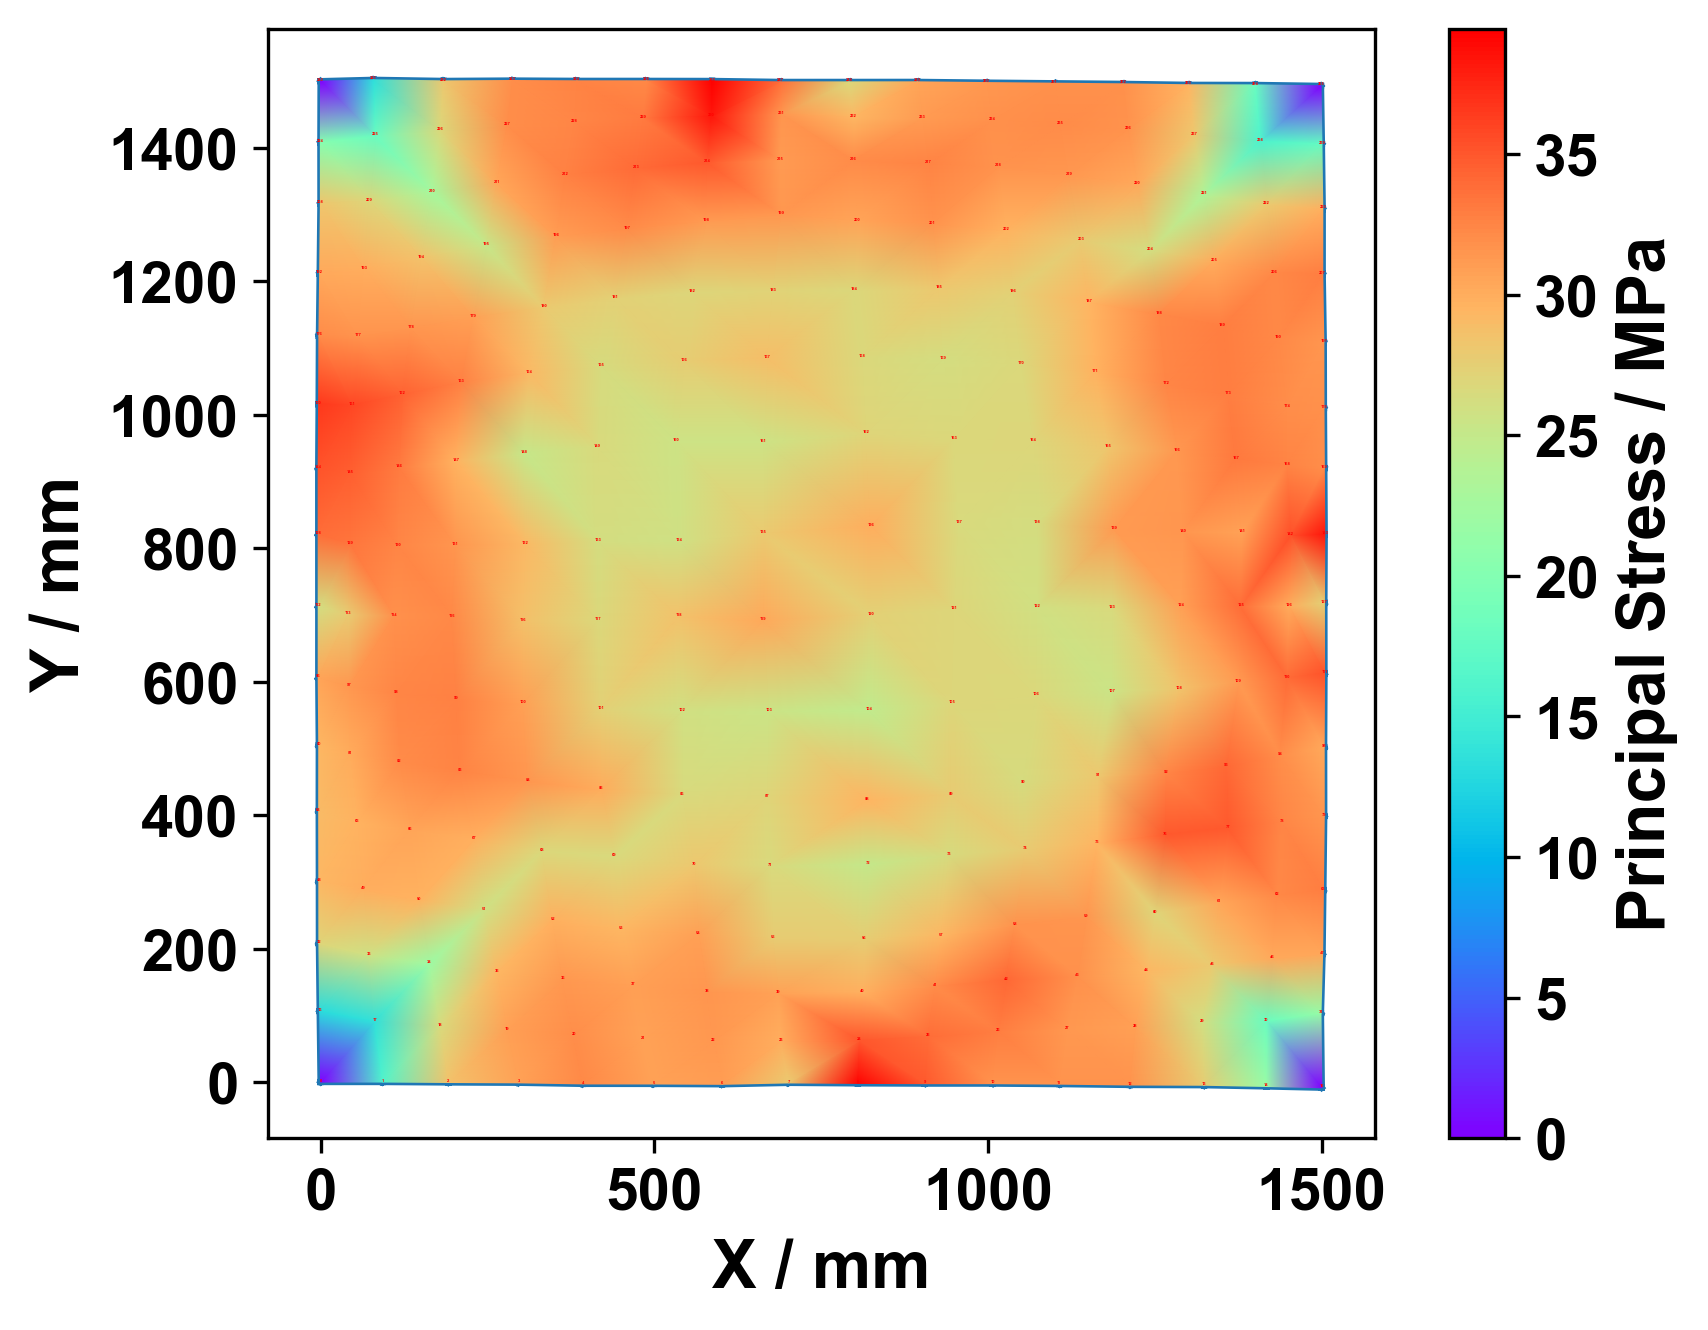

In [14]:
# Calculate the principal stresses at each point in the interior to be stored and then interpolated
def find_Sxx(ID):
    index1 = links_x[(links_x['point1_ID'] == ID)].index.tolist()
    index2 = links_x[(links_x['point2_ID'] == ID)].index.tolist()
    index = index1 + index2
    S = 0
    for i in range(len(index)):
        S += links_x.loc[index[i], 'stress']
    Sxx = S / len(index)
    return Sxx
def find_Syy(ID):
    index1 = links_y[(links_y['point1_ID'] == ID)].index.tolist()
    index2 = links_y[(links_y['point2_ID'] == ID)].index.tolist()
    index = index1 + index2
    S = 0
    for i in range(len(index)):
        S += links_y.loc[index[i], 'stress']
    Syy = S / len(index)
    return Syy

points['principal_stress'] = None
for i in range(points.shape[0]):
    ID = np.int0(points.loc[i, 'point_ID'])
    points.loc[i, 'principal_stress'] = max(find_Sxx(ID), find_Syy(ID)) # Without considering the shear stress Sxy

# Plot the maximum principal stresses distribution stored in the nodes
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.autoscale()

plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X / mm')
plt.ylabel('Y / mm')

plt.triplot(triang)

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points.loc[i, 'point_ID'],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

list = points['principal_stress'].tolist()
cp = plt.tripcolor(triang, list, cmap='rainbow', shading='gouraud')
cb = plt.colorbar(label="Principal Stress / MPa")
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2780\350403861.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  ID = np.int0(points.loc[i, 'point_ID'])


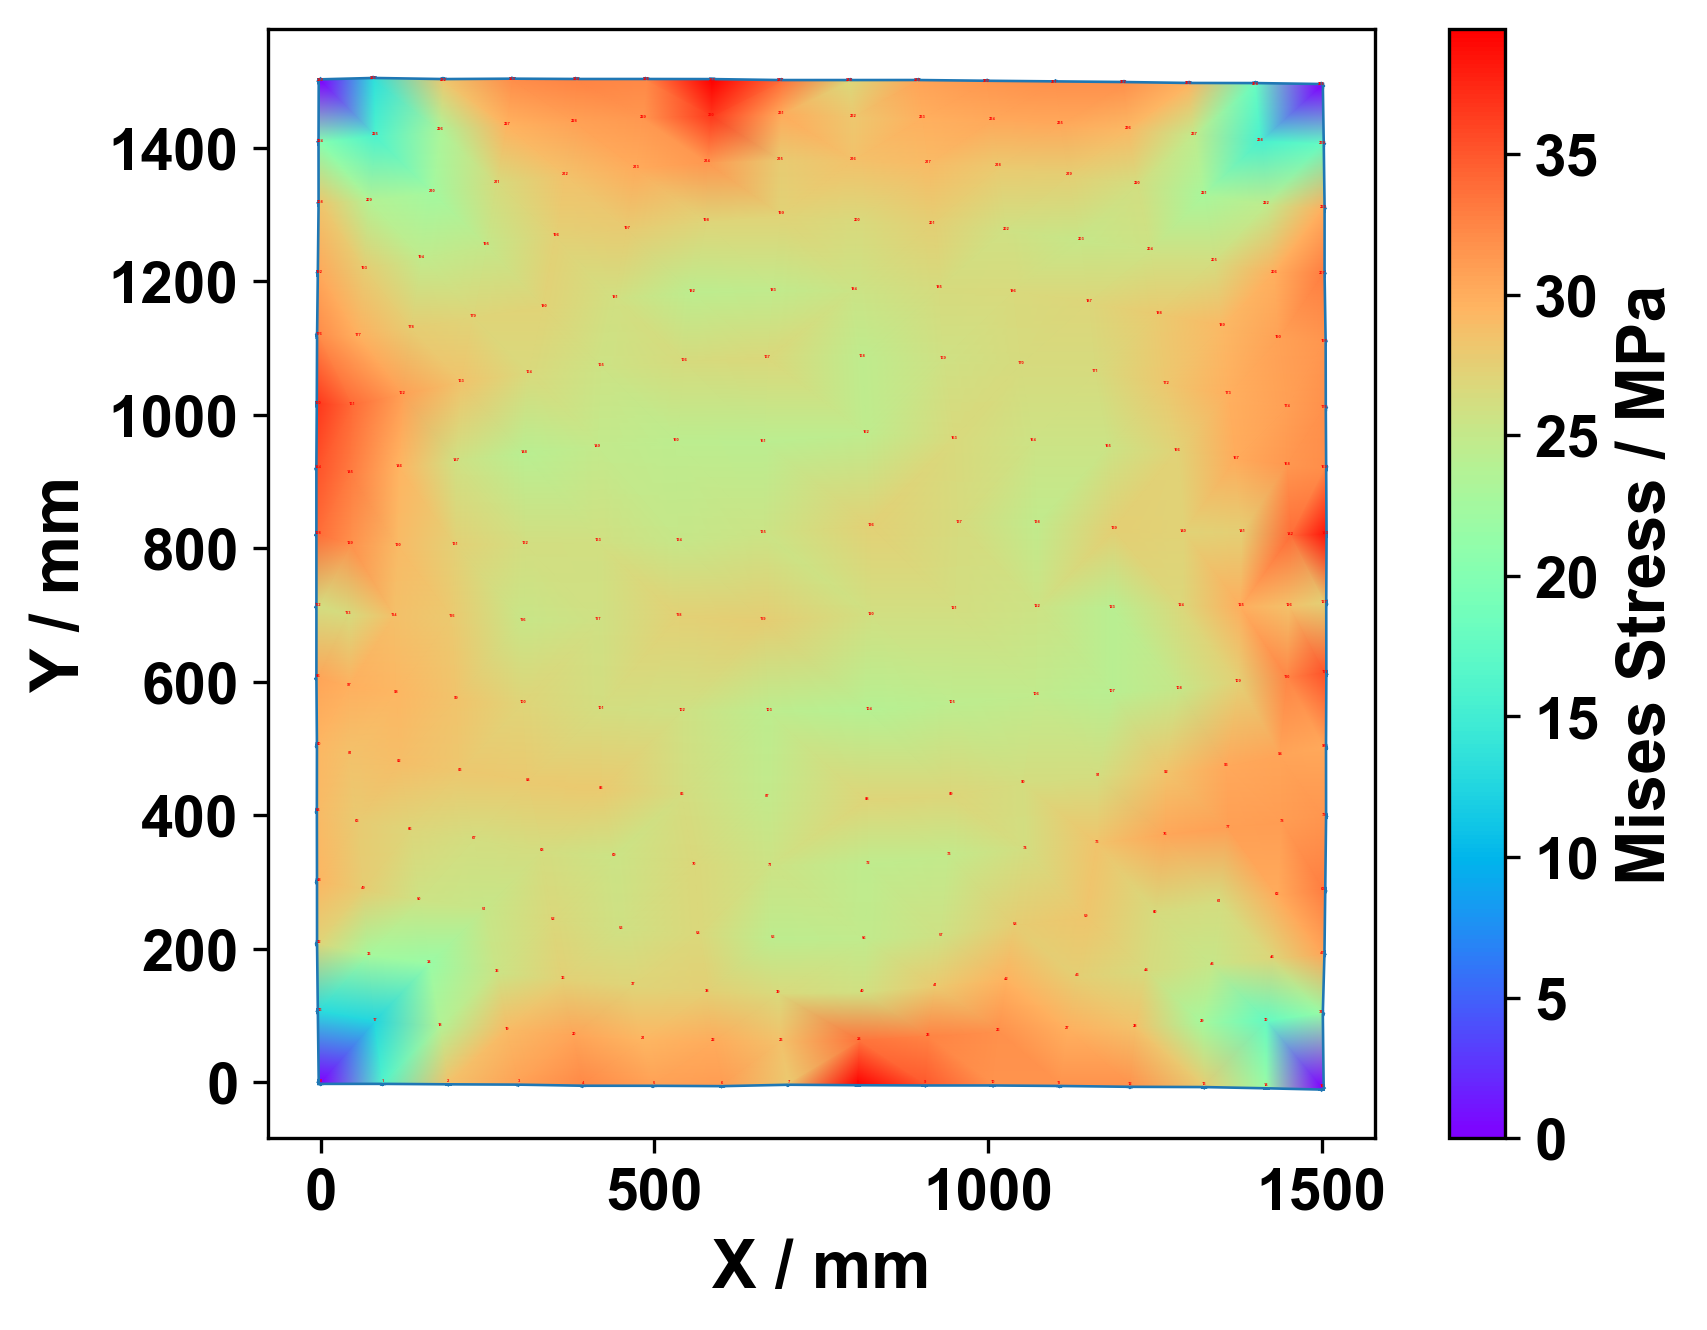

In [15]:
# Calculate and plot Mises stresses on the membrane surface
points['mises_stress'] = None
for i in range(points.shape[0]):
    ID = np.int0(points.loc[i, 'point_ID'])
    smax = max(find_Sxx(ID), find_Syy(ID))
    smin = min(find_Sxx(ID), find_Syy(ID))
    se = np.sqrt(1/2*(smax**2 + smin**2 + (smax-smin)**2))
    points.loc[i, 'mises_stress'] = se # 不考虑剪应力Sxy
del ID, smax, smin, se

# Plotting the mises stress distribution stored in the node
plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
ax.autoscale()
plt.triplot(triang)

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points.loc[i, 'point_ID'],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

list = points['mises_stress'].tolist()
cp = plt.tripcolor(triang, list, cmap='rainbow', shading='gouraud')
cb = plt.colorbar(label="Mises Stress / MPa")
plt.show()

(-100.0, 1600.0, -100.0, 1600.0)

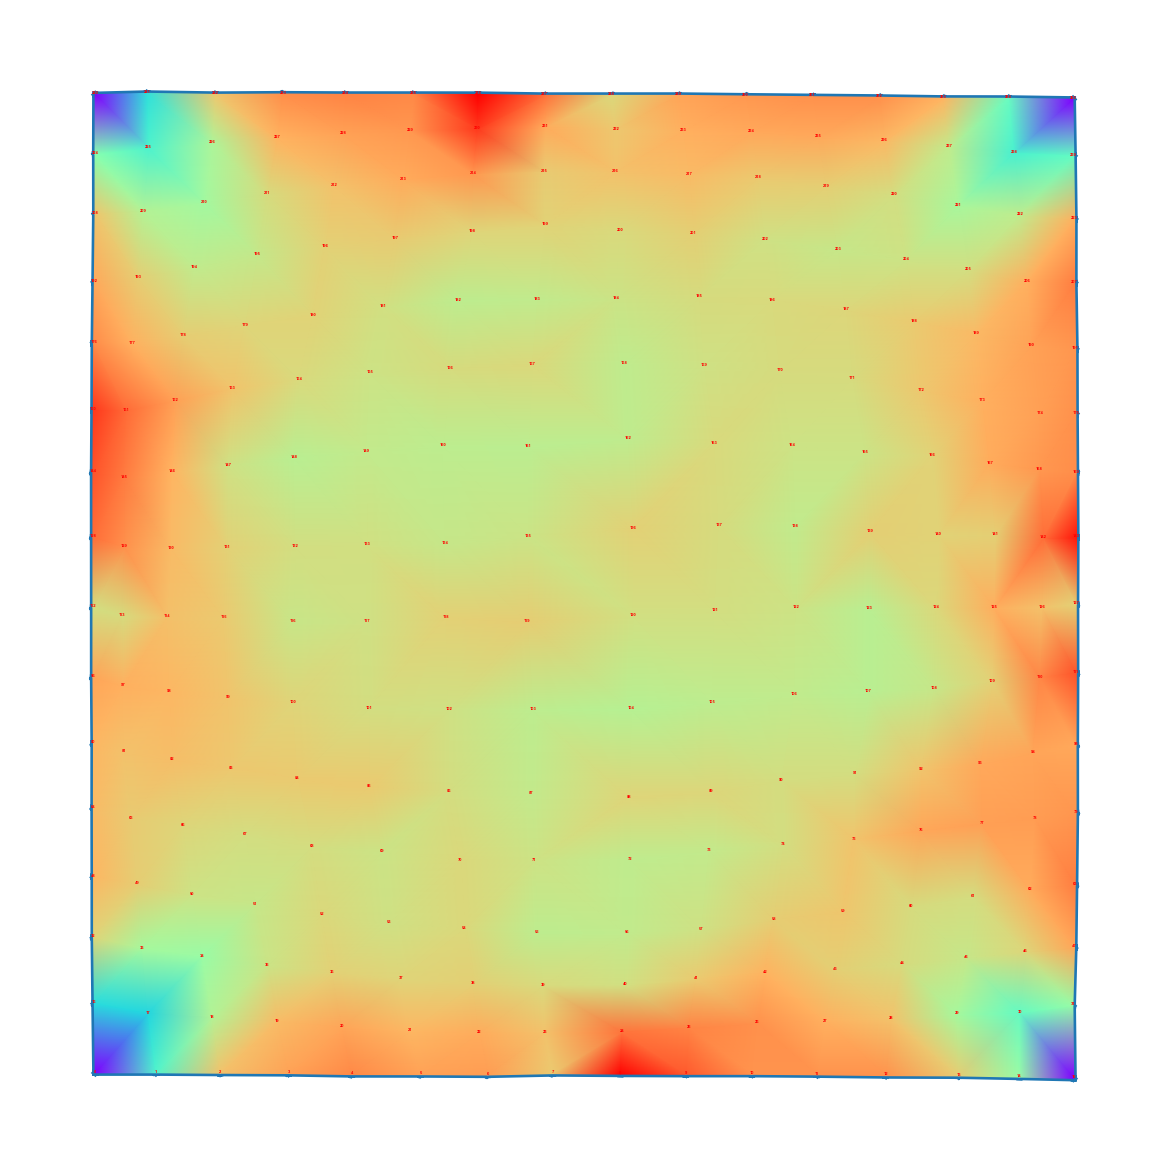

In [16]:
# Plot the mises stress distribution stored in the nodes and remove the axes and colour bars
plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-100, 1600))
plt.ylim((-100, 1600))
plt.xticks(np.arange(0, 1500, 200))
plt.xticks(np.arange(0, 1500, 200))
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
ax.autoscale()
plt.triplot(triang)

for i in range(xy.shape[0]):
    plt.text(xy[i][0], xy[i][1],
            points.loc[i, 'point_ID'],
            fontsize = 0,
            color = 'r', 
            horizontalalignment = 'center',
            verticalalignment = 'bottom')

list = points['mises_stress'].tolist()
cp = plt.tripcolor(triang, list, cmap='rainbow', shading='gouraud')
#cb = plt.colorbar(label="Mises Stress / MPa")
plt.axis('off')